In [2]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

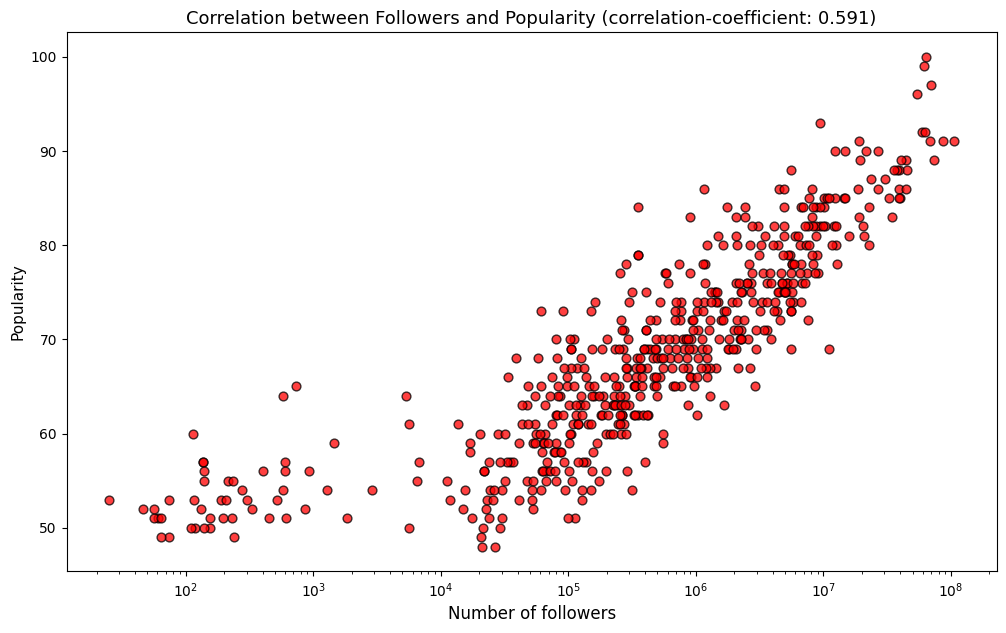

In [16]:
df = pd.read_csv("track_spotify_data.csv")
unique_artists = df['artist_name'].unique().tolist()

artists_followers_popularity = {}
for artist in unique_artists:
    rows_specific_artist = df.loc[df['artist_name'] == artist]
    
    unique_followers = rows_specific_artist['artist_followers'].unique().tolist()
    all_same_followers = all(followers == unique_followers[0] for followers in unique_followers)
    if not all_same_followers:
        print(f"Contradicting follower counts with artist {artist}")
    
    unique_popularity = rows_specific_artist['artist_popularity'].unique().tolist()
    all_same_popularity = all(followers == unique_followers[0] for followers in unique_followers)
    if not all_same_popularity:
        print(f"Contradicting popularity counts with artist {artist}")
        
    followers_popularity_tuple = (unique_followers[0], unique_popularity[0])
    artists_followers_popularity[artist] = followers_popularity_tuple

x = []
y = []

for artist in artists_followers_popularity:
    x.append(artists_followers_popularity[artist][0])
    y.append(artists_followers_popularity[artist][1])
    
print()

sum_xy = 0
sum_x = 0
sum_y = 0
sum_xsquared = 0
sum_ysquared = 0
counter = 0
for value_x, value_y in zip(x, y):
    counter += 1
    sum_x += value_x
    sum_y += value_y
    sum_xsquared += value_x ** 2
    sum_ysquared += value_y ** 2
    sum_xy += value_x * value_y
        
r = (counter*sum_xy-sum_x*sum_y)/(((counter*sum_xsquared-sum_x**2)*(counter*sum_ysquared-sum_y**2))**0.5)
r = round(r, 3)

figure, axis = plt.subplots(figsize=(12, 7))
plt.subplot()
plt.scatter(x, y, s=40, c='red', edgecolor='black', linewidth=1, alpha=0.75)
plt.title(f"Correlation between Followers and Popularity (correlation-coefficient: {r})", fontsize = 13)
axis.set_xlabel("Number of followers", fontsize = 12)
axis.set_ylabel("Popularity", fontsize = 11)
plt.xscale('log')
plt.show()